In [3]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,precision_score, recall_score
from torchsummary import summary

In [22]:
data_dir = 'E:/train_data'

In [23]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [24]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}

In [25]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 13619
     Root location: E:/train_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 2719
     Root location: E:/train_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1825
     Root location: E:/train_data\test
     StandardTransform
 Transform: Compose(
            

In [26]:
class_names=image_datasets['train'].classes

In [27]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [28]:
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda', index=0)

In [46]:
model_alexnet = models.alexnet(pretrained=True)

In [47]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [48]:
num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs,len(class_names) )

In [49]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [52]:
model_alexnet= model_alexnet.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()

In [54]:
optimizer_conv = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_alexnet = train_model(model_alexnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.8061 Acc: 0.7353
val Loss: 0.3838 Acc: 0.8694

Epoch 1/24
----------
train Loss: 0.4405 Acc: 0.8528
val Loss: 0.3505 Acc: 0.8838

Epoch 2/24
----------
train Loss: 0.3281 Acc: 0.8883
val Loss: 0.2424 Acc: 0.9180

Epoch 3/24
----------
train Loss: 0.2780 Acc: 0.9053
val Loss: 0.1230 Acc: 0.9592

Epoch 4/24
----------
train Loss: 0.2650 Acc: 0.9115
val Loss: 0.1680 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.2268 Acc: 0.9256
val Loss: 0.1056 Acc: 0.9647

Epoch 6/24
----------
train Loss: 0.2114 Acc: 0.9281
val Loss: 0.2255 Acc: 0.9349

Epoch 7/24
----------
train Loss: 0.1124 Acc: 0.9617
val Loss: 0.0479 Acc: 0.9860

Epoch 8/24
----------
train Loss: 0.0953 Acc: 0.9692
val Loss: 0.0570 Acc: 0.9816

Epoch 9/24
----------
train Loss: 0.0915 Acc: 0.9686
val Loss: 0.0411 Acc: 0.9860

Epoch 10/24
----------
train Loss: 0.0841 Acc: 0.9717
val Loss: 0.0384 Acc: 0.9868

Epoch 11/24
----------
train Loss: 0.0900 Acc: 0.9701
val Loss: 0.0390 Acc: 0.9875

Ep

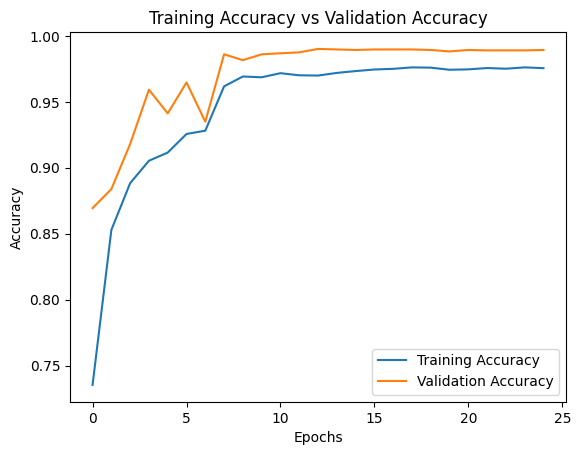

In [1]:
import matplotlib.pyplot as plt

# Example data
epochs = [i for i in range(25)]
train_acc = [0.7353, 0.8528, 0.8883, 0.9053, 0.9115, 0.9256, 0.9281, 0.9617, 0.9692, 0.9686, 0.9717, 0.9701, 0.9699, 0.9719, 0.9733, 0.9745, 0.9750, 0.9761, 0.9759, 0.9743, 0.9746, 0.9756, 0.9751, 0.9761, 0.9755]
val_acc = [0.8694, 0.8838, 0.9180, 0.9592, 0.9412, 0.9647, 0.9349, 0.9860, 0.9816, 0.9860, 0.9868, 0.9875, 0.9901, 0.9897, 0.9893, 0.9897, 0.9897, 0.9897, 0.9893, 0.9882, 0.9893, 0.9890, 0.9890, 0.9890, 0.9893]


# Plotting the data
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

# Display the plot
plt.show()

In [55]:
torch.save(model_alexnet,'alexnet-model1.pth')

In [4]:
model_alexnet = torch.load('alexnet-model1.pth')

In [32]:
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
with torch.no_grad():
    
    accuracy = 0
    total_samples = 0
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

    
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        
        outputs = model_alexnet(images)

        
        _, predicted = torch.max(outputs.data, 1)

       
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Append predicted and true labels to lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

  
    accuracy = correct_predictions / total_samples

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    f_score = f1_score(true_labels, predicted_labels, average='weighted')

    
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Accuracy: {:.5f}%".format(accuracy))

Accuracy: 0.99123%


In [35]:
print("Precision: {:.5f}".format(precision))

Precision: 0.99135


In [36]:
print("Recall: {:.5f}".format(recall))

Recall: 0.99123


In [39]:
print("F-score: {:.5f}".format(f_score))

F-score: 0.99125


In [40]:
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  99   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 212   0   0   0   0   0   1   0   0   0]
 [  0   0   0   2  97   1   0   0   0   0   0   0   0]
 [  0   1   0   0   0 190   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0  96   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 175   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0 166   2   0   0   0]
 [  0   0   0   0   0   0   0   1   0 140   0   0   0]
 [  0   0   0   3   0   0   0   0   0   0 319   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  39   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 160]]


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

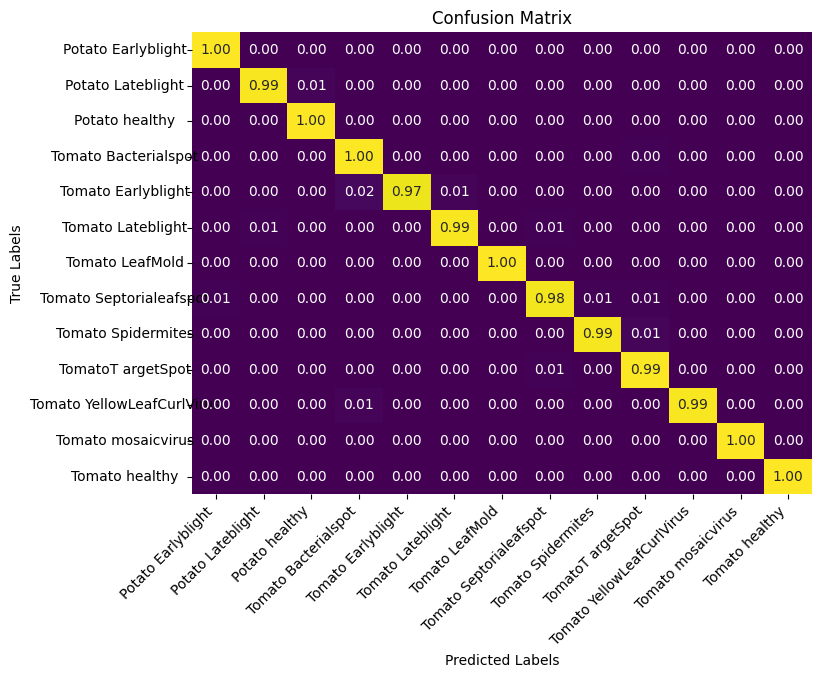

In [43]:

class_labels =  ['Potato Earlyblight','Potato Lateblight','Potato healthy','Tomato Bacterialspot','Tomato Earlyblight',
                 'Tomato Lateblight','Tomato LeafMold','Tomato Septorialeafspot','Tomato Spidermites','TomatoT argetSpot',
                 'Tomato YellowLeafCurlVirus','Tomato mosaicvirus','Tomato healthy']

normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots(figsize=(8, 6))


heatmap = sns.heatmap(normalized_confusion_mat, annot=True, fmt='.2f', cmap='viridis', cbar=False, ax=ax)


ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

heatmap.set_xticklabels(class_labels, rotation=45, ha='right')
heatmap.set_yticklabels(class_labels, rotation=0, ha='center')


ax.tick_params(axis='y', pad=45)


plt.xticks(rotation=45)



plt.show()

In [1]:
from torchsummary import summary

In [5]:
summary(model_alexnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25